In [79]:
import pandas as pd
import copy
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.interpolate import make_interp_spline
import os

In [80]:
df_copy = pd.read_csv("Wildfire_Dataset.csv")

/tmp/ipykernel_18301/3328195843.py:1: DtypeWarning: Columns (7,8,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_copy = pd.read_csv("Wildfire_Dataset.csv")


In [81]:
df = copy.deepcopy(df_copy)
df.drop(["Unnamed: 0", "FIPS_CODE"], axis=1, inplace=True)

In [82]:
columns = {'FIRE_YEAR': "year",
       'DISCOVERY_DATE': "discovery_date", 'DISCOVERY_DOY': "discovery_doy", 'DISCOVERY_TIME': "discovery_time",
       'NWCG_CAUSE_CLASSIFICATION': "cause_class", 'NWCG_GENERAL_CAUSE': "cause_description",
       'NWCG_CAUSE_AGE_CATEGORY': "cause_age", 'CONT_DATE': "contained_date", 'CONT_DOY': "contained_doy", 'CONT_TIME': "contained_time",
       'FIRE_SIZE': "size", 'FIRE_SIZE_CLASS': "size_class", 'LATITUDE': "latitude", 'LONGITUDE': "longitude", 
       'STATE': "state", 'COUNTY': "county", 'FIPS_CODE': "fips_code", 'FIPS_NAME': "fips_name"}

df.rename(mapper= lambda column: columns[column] if column in columns.keys() else column, axis=1, inplace=True)

df["discovery_month"] = df["discovery_date"].apply(lambda date: date.split("/")[1])
df["discovery_day"] = df["discovery_date"].apply(lambda date: date.split("/")[0])


def calc_duration(series: pd.Series):
     if any(math.isnan(x) if (type(x) is not str) else False for x in [series["contained_doy"], series ["discovery_doy"], series["contained_date"], series["year"]]):
          return None
     return series["contained_doy"] - series ["discovery_doy"] + (int(series["contained_date"].split("/")[-1]) - series["year"]) * 365 + 1

df["duration"] = df.apply(func= calc_duration, axis=1)

In [83]:
df

,year,discovery_date,discovery_doy,discovery_time,cause_class,cause_description,cause_age,contained_date,contained_doy,contained_time,size,size_class,latitude,longitude,state,county,fips_name,discovery_month,discovery_day,duration
0,2005,2/2/2005,33,1300.0,Human,Power generation/transmission/distribution,NaN,2/2/2005,33.0,1730.0,0.10,A,40.036944,-121.005833,CA,63.0,Plumas County,2,2,1.0
1,2004,5/12/2004,133,845.0,Natural,Natural,NaN,5/12/2004,133.0,1530.0,0.25,A,38.933056,-120.404444,CA,61.0,Placer County,12,5,1.0
2,2004,5/31/2004,152,1921.0,Human,Debris and open burning,NaN,5/31/2004,152.0,2024.0,0.10,A,38.984167,-120.735556,CA,17.0,El Dorado County,31,5,1.0
3,2004,6/28/2004,180,1600.0,Natural,Natural,NaN,7/3/2004,185.0,1400.0,0.10,A,38.559167,-119.913333,CA,3.0,Alpine County,28,6,6.0
4,2004,6/28/2004,180,1600.0,Natural,Natural,NaN,7/3/2004,185.0,1200.0,0.10,A,38.559167,-119.933056,CA,3.0,Alpine County,28,6,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2303561,2020,6/5/2020,157,1741.0,Natural,Natural,NaN,NaN,NaN,NaN,1.00,B,39.037890,-108.959500,CO,NaN,NaN,5,6,NaN
2303562,2020,7/11/2020,193,1958.0,Missing data/not specified/undetermined,Missing data/not specified/undetermined,NaN,NaN,NaN,NaN,100.00,D,37.148611,-119.503056,CA,Madera,Madera County,11,7,NaN
2303563,2020,8/27/2020,240,1911.0,Natural,Natural,NaN,NaN,NaN,NaN,50.00,C,46.151370,-114.442800,MT,NaN,NaN,27,8,NaN
2303564,2020,8/17/2020,230,755.0,Natural,Natural,NaN,8/20/2020,233.0,1900.0,24892.00,G,46.670340,-120.114500,WA,Yakima,Yakima County,17,8,4.0


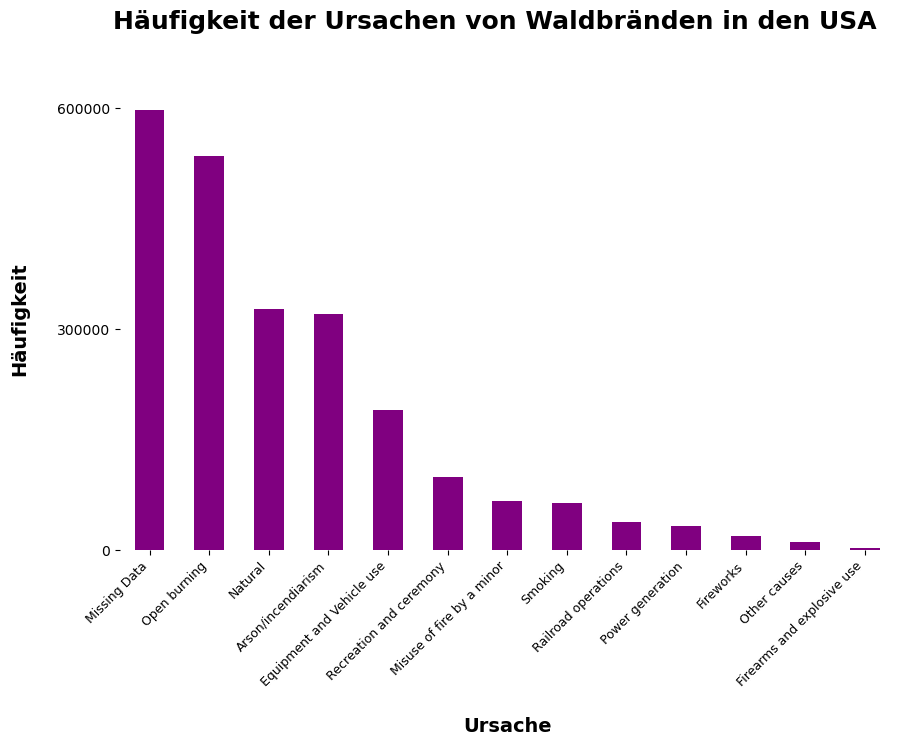

In [84]:
#Christophs Code
cause_counts = df['cause_description'].value_counts()

fig, ax = plt.subplots(figsize = (10, 6))


bars = cause_counts.plot(kind = 'bar', color = 'purple', ax = ax)
#ax.set_title('Häufigkeit der Ursachen von Waldbränden in den USA', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Ursache', fontsize = 14, fontweight = 'bold', labelpad = 20)
ax.set_ylabel('Häufigkeit', fontsize = 14, fontweight = 'bold', labelpad = 20)

new_labels = ['Missing Data', 'Open burning', 'Natural', 'Arson/incendiarism', 'Equipment and Vehicle use', 'Recreation and ceremony', 'Misuse of fire by a minor', 'Smoking', 'Railroad operations', 'Power generation', 'Fireworks', 'Other causes', 'Firearms and explosive use']
ax.set_xticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, rotation = 45, ha = 'right', fontsize = 9)
ax.tick_params(axis = 'y', labelsize = 9)

yticks = ax.get_yticks()
new_yticks = [yticks[0], yticks[3], yticks[-2]]  # Nur den 3. und letzten Wert nehmen
new_y_labels = [f'{int(new_yticks[0])}', f'{int(new_yticks[1])}', f'{int(new_yticks[-1])}']
ax.set_yticks(new_yticks)
ax.set_yticklabels(new_y_labels, fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.suptitle('Häufigkeit der Ursachen von Waldbränden in den USA', fontsize=18, fontweight='bold', y = 1.01, x = 0.5)

plt.show()

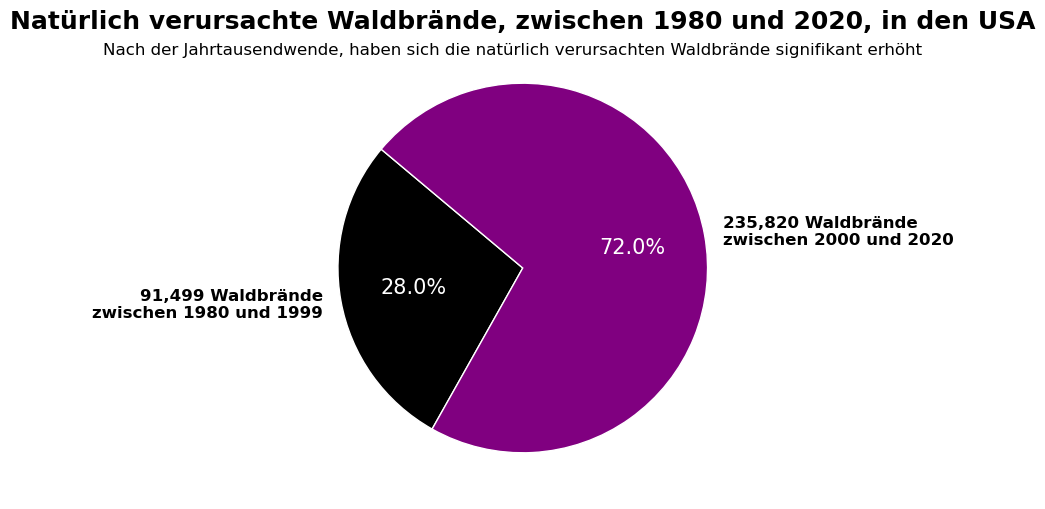

In [85]:
df['discovery_date'] = pd.to_datetime(df['discovery_date'])

start_date_1 = pd.to_datetime('1980-01-01')
end_date_1 = pd.to_datetime('1999-12-31')

start_date_2 = pd.to_datetime('2000-01-01')
end_date_2 =  pd.to_datetime('2020-12-31')

specific_cause = 'Natural'
filtered_df_1 = df[(df['discovery_date'] >= start_date_1) & (df['discovery_date'] <= end_date_1) & (df['cause_description'] == specific_cause)]
filtered_df_2 = df[(df['discovery_date'] >= start_date_2) & (df['discovery_date'] <= end_date_2) & (df['cause_description'] == specific_cause)]

total_fires_1 = filtered_df_1[(filtered_df_1['discovery_date'] >= start_date_1) & (filtered_df_1['discovery_date'] <= end_date_1)].shape[0]
total_fires_2 = filtered_df_2[(filtered_df_2['discovery_date'] >= start_date_2) & (filtered_df_2['discovery_date'] <= end_date_2)].shape[0]

cause_counts_1 = filtered_df_1.shape[0]
cause_counts_2 = filtered_df_2.shape[0]

plt.figure(figsize = (8, 6))

labels = [f'{total_fires_1:,} Waldbrände\nzwischen 1980 und 1999',
          f'{total_fires_2:,} Waldbrände\nzwischen 2000 und 2020']
sizes = [cause_counts_1, cause_counts_2]

def autopct_format(pct):
    value = pct * sum(sizes) / 100.0
    return f'{pct:.1f}%'

colors = ['black', 'purple']

patches, texts, autotexts = plt.pie(sizes, labels = labels, colors = colors, shadow = False, startangle = 140, wedgeprops={'edgecolor': 'white'}, autopct = autopct_format)

for i, text in enumerate(texts):
    text.set_fontweight('bold') 
    text.set_fontsize(12)  
    
    ang = (patches[i].theta2 + patches[i].theta1) / 2
    x = np.cos(np.radians(ang))
    y = np.sin(np.radians(ang))
    
    if x > 0:
        ha = 'left'
    else:
        ha = 'right'
    text.set_horizontalalignment(ha)

for autotext in autotexts:
    autotext.set_fontsize(15)
    autotext.set_color('white')

title = plt.title(f'Natürlich verursachte Waldbrände, zwischen 1980 und 2020, in den USA', fontsize=18, fontweight = 'bold')
title.set_position([0.5, 0.9])
plt.figtext(0.5, 0.85, "Nach der Jahrtausendwende, haben sich die natürlich verursachten Waldbrände signifikant erhöht", 
            wrap=True, horizontalalignment='center', fontsize=12)


plt.gca().set_aspect('equal')
plt.show()

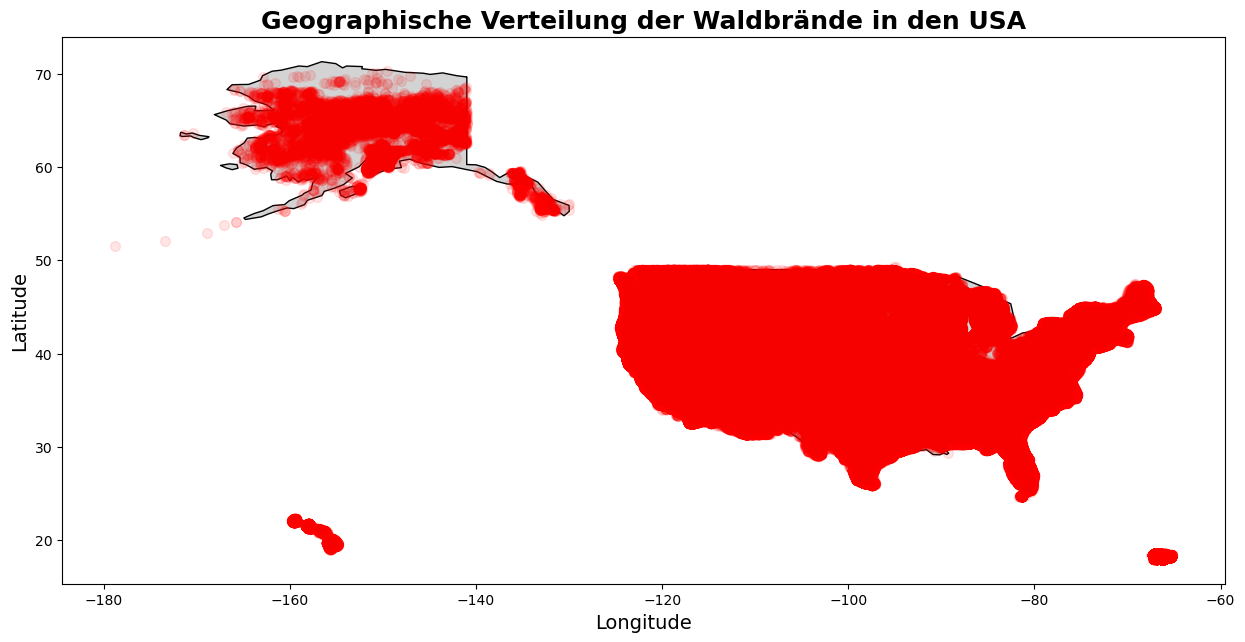

In [88]:

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))


world_path = 'countries/ne_110m_admin_0_countries.shp'  # Pfad zur Shapefile anpassen
world = gpd.read_file(world_path)

usa = world[world['ADMIN'] == 'United States of America']

# Plot erstellen
fig, ax = plt.subplots(figsize=(15, 10))

# USA-Grenzen plotten
usa.plot(ax=ax, color='lightgrey', edgecolor='black')

# Waldbrände plotten
gdf.plot(ax=ax, color='red', markersize=50, marker='o', alpha=0.1)  # alpha für Transparenz

# Titel und Achsenbeschriftungen setzen
plt.title('Geographische Verteilung der Waldbrände in den USA', fontsize=18, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

plt.show()